In [1]:
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os
from collections import Counter

!pip install openpyxl


In [ ]:
!pip install -q huggingface_hub
from huggingface_hub import login, create_repo, upload_folder

In [ ]:
!pip install openpyxl

In [2]:
df = pd.read_excel("dataset_final.xlsx")
df = df.dropna(subset=["full_text", "label"])

In [3]:
# Konversi datetime
df["created_at"] = pd.to_datetime(df["created_at"])
if df["created_at"].dt.tz is None:
    df["created_at"] = df["created_at"].dt.tz_localize("UTC")
df["created_at"] = df["created_at"].dt.tz_convert(None)

# Hitung tweet per day
df["min_date"] = df.groupby("user_id_str")["created_at"].transform("min")
df["max_date"] = df.groupby("user_id_str")["created_at"].transform("max")
df["days_active"] = (df["max_date"] - df["min_date"]).dt.days + 1
df["tweet_count"] = df.groupby("user_id_str")["user_id_str"].transform("count")
df["tweet_per_day"] = df["tweet_count"] / df["days_active"]
df.drop(["min_date", "max_date", "days_active", "tweet_count"], axis=1, inplace=True)

# Bersihkan teks
def clean_text(text):
    text = re.sub(r"http\S+", "", str(text))
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    return text.strip()

df["clean_text"] = df["full_text"].apply(clean_text)

# Standarisasi fitur numerik
numerical_cols = ["favorite_count", "retweet_count", "reply_count", "quote_count", "tweet_per_day"]
df[numerical_cols] = df[numerical_cols].fillna(0)
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Label encoding
le = LabelEncoder()
df["label_encoded"] = le.fit_transform(df["label"])


/tmp/ipython-input-34689536.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["created_at"] = pd.to_datetime(df["created_at"])


In [4]:
df.head()

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username,label,tweet_per_day,clean_text,label_encoded
0,1873697576354217984,2024-12-30 14:21:18,-0.175800,@THALAIVARBB @rajinikanth @KRAJBO55 @ragul29 @...,1873736120326074880,NaN,THALAIVARBB,in,NaN,-0.084072,-0.18442,-0.130953,https://x.com/SATHISHKUMARU10/status/187373612...,825008806002176000,SATHISHKUMARU10,bot,-0.545375,OM MURUGAA,0
1,1873346231449300992,2024-12-29 13:23:27,-0.175800,@THALAIVARBB OM MURUGAA,1873359176086503936,NaN,THALAIVARBB,in,NaN,-0.084072,-0.18442,-0.130953,https://x.com/SATHISHKUMARU10/status/187335917...,825008806002176000,SATHISHKUMARU10,bot,-0.545375,OM MURUGAA,0
2,1872862587567910912,2024-12-28 04:49:03,-0.175800,@THALAIVARBB @rajinikanth @KRAJBO55 @ragul29 @...,1872867334811205888,NaN,THALAIVARBB,in,NaN,-0.084072,-0.18442,-0.130953,https://x.com/SATHISHKUMARU10/status/187286733...,825008806002176000,SATHISHKUMARU10,bot,-0.545375,OM MURUGAA,0
3,1872616709712229120,2024-12-27 13:03:53,-0.175538,@THALAIVARBB @rajinikanth @KRAJBO55 @ragul29 @...,1872629476317901056,NaN,THALAIVARBB,in,NaN,-0.084072,-0.18442,-0.130953,https://x.com/SATHISHKUMARU10/status/187262947...,825008806002176000,SATHISHKUMARU10,bot,-0.545375,OM MURUGAA,0
4,1872224617231973888,2024-12-26 10:22:09,-0.175800,@THALAIVARBB @rajinikanth @KRAJBO55 @ragul29 @...,1872226384623567104,NaN,THALAIVARBB,in,NaN,-0.084072,-0.18442,-0.130953,https://x.com/SATHISHKUMARU10/status/187222638...,825008806002176000,SATHISHKUMARU10,bot,-0.545375,OM MURUGAA,0


In [5]:
def tokenize(text):
    return text.split()

tokenized_texts = df["clean_text"].apply(tokenize)
word_counts = Counter(word for tokens in tokenized_texts for word in tokens)
vocab = {word: i+2 for i, (word, _) in enumerate(word_counts.items())}
vocab["<PAD>"] = 0
vocab["<UNK>"] = 1

def encode(tokens):
    return [vocab.get(token, 1) for token in tokens]

encoded_texts = [torch.tensor(encode(tokens)) for tokens in tokenized_texts]
padded_texts = pad_sequence(encoded_texts, batch_first=True)

text_tensor = padded_texts
numerical_tensor = torch.tensor(df[numerical_cols].values, dtype=torch.float32)
label_tensor = torch.tensor(df["label_encoded"].values)


In [6]:
X_train, X_test, num_train, num_test, y_train, y_test = train_test_split(
    text_tensor, numerical_tensor, label_tensor, test_size=0.2, random_state=42
)

class BotDataset(Dataset):
    def __init__(self, texts, numerics, labels):
        self.texts = texts
        self.numerics = numerics
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.numerics[idx], self.labels[idx]

train_dataset = BotDataset(X_train, num_train, y_train)
test_dataset = BotDataset(X_test, num_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [7]:
class BotDetector(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_numeric, output_dim):
        super(BotDetector, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc_text = nn.Linear(hidden_dim, 64)
        self.fc_numeric = nn.Linear(num_numeric, 32)
        self.classifier = nn.Sequential(
            nn.ReLU(),
            nn.Linear(96, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )

    def forward(self, x_text, x_num):
        x = self.embedding(x_text)
        _, (h_n, _) = self.lstm(x)
        text_out = self.fc_text(h_n[-1])
        num_out = self.fc_numeric(x_num)
        combined = torch.cat((text_out, num_out), dim=1)
        return self.classifier(combined)


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BotDetector(
    vocab_size=len(vocab),
    embed_dim=100,
    hidden_dim=128,
    num_numeric=len(numerical_cols),
    output_dim=len(le.classes_)
).to(device)

weights = torch.tensor([0.7, 0.3]).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=0.0005)


history = {
    "epoch": [],
    "train_loss": [],
    "train_acc": [],
    "train_prec": [],
    "train_rec": [],
    "train_f1": [],
    "train_roc": [],
    "test_acc": [],
    "test_prec": [],
    "test_rec": [],
    "test_f1": [],
    "test_roc": [],
}

for epoch in range(10):
    model.train()
    total_loss = 0
    for x_text, x_num, y in train_loader:
        x_text, x_num, y = x_text.to(device), x_num.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x_text, x_num)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    # ⏳ Evaluasi Train
    train_acc, train_prec, train_rec, train_f1, train_roc = evaluate(model, train_loader, device)

    # ⏱️ Evaluasi Test
    test_acc, test_prec, test_rec, test_f1, test_roc = evaluate(model, test_loader, device)

    # Simpan ke history
    history["epoch"].append(epoch + 1)
    history["train_loss"].append(avg_loss)
    history["train_acc"].append(train_acc)
    history["train_prec"].append(train_prec)
    history["train_rec"].append(train_rec)
    history["train_f1"].append(train_f1)
    history["train_roc"].append(train_roc)
    history["test_acc"].append(test_acc)
    history["test_prec"].append(test_prec)
    history["test_rec"].append(test_rec)
    history["test_f1"].append(test_f1)
    history["test_roc"].append(test_roc)

    # Tampilkan per epoch
    print(f"\n📊 Epoch {epoch+1}")
    print(f"Train Loss   : {avg_loss:.4f}")
    print(f"Train Acc    : {train_acc:.4f} | Prec: {train_prec:.4f} | Rec: {train_rec:.4f} | F1: {train_f1:.4f} | ROC AUC: {train_roc:.4f}")
    print(f"Test  Acc    : {test_acc:.4f}  | Prec: {test_prec:.4f}  | Rec: {test_rec:.4f}  | F1: {test_f1:.4f}  | ROC AUC: {test_roc:.4f}")
    print("="*60)



📊 Epoch 1
Train Loss   : 0.4264
Train Acc    : 0.8552 | Prec: 0.8550 | Rec: 0.8548 | F1: 0.8549 | ROC AUC: 0.0000
Test  Acc    : 0.8246  | Prec: 0.8240  | Rec: 0.8248  | F1: 0.8243  | ROC AUC: 0.0000

📊 Epoch 2
Train Loss   : 0.2886
Train Acc    : 0.8741 | Prec: 0.8791 | Rec: 0.8767 | F1: 0.8740 | ROC AUC: 0.0000
Test  Acc    : 0.8291  | Prec: 0.8367  | Rec: 0.8334  | F1: 0.8289  | ROC AUC: 0.0000

📊 Epoch 3
Train Loss   : 0.2375
Train Acc    : 0.9204 | Prec: 0.9218 | Rec: 0.9193 | F1: 0.9201 | ROC AUC: 0.0000
Test  Acc    : 0.8635  | Prec: 0.8636  | Rec: 0.8624  | F1: 0.8629  | ROC AUC: 0.0000

📊 Epoch 4
Train Loss   : 0.1845
Train Acc    : 0.9312 | Prec: 0.9330 | Rec: 0.9329 | F1: 0.9312 | ROC AUC: 0.0000
Test  Acc    : 0.8354  | Prec: 0.8419  | Rec: 0.8394  | F1: 0.8353  | ROC AUC: 0.0000

📊 Epoch 5
Train Loss   : 0.1412
Train Acc    : 0.9598 | Prec: 0.9598 | Rec: 0.9607 | F1: 0.9598 | ROC AUC: 0.0000
Test  Acc    : 0.8543  | Prec: 0.8559  | Rec: 0.8565  | F1: 0.8543  | ROC AUC: 0.

In [11]:
def evaluate(model, data_loader, device):
    model.eval()
    all_preds, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for x_text, x_num, y in data_loader:
            x_text, x_num, y = x_text.to(device), x_num.to(device), y.to(device)
            outputs = model(x_text, x_num)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(y.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average="macro", zero_division=0)
    rec = recall_score(all_labels, all_preds, average="macro", zero_division=0)
    f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)
    try:
        roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro')
    except ValueError:
        roc_auc = 0.0

    return acc, prec, rec, f1, roc_auc


In [12]:
for i in range(15):
    print(f"Original cleaned text: {df['clean_text'].iloc[i]}")
    print(f"Tokenized: {tokenized_texts.iloc[i]}")
    print(f"Encoded: {encoded_texts[i].tolist()}")
    print(f"Padded : {padded_texts[i].tolist()}")
    print("-" * 60)

Original cleaned text: OM MURUGAA
Tokenized: ['OM', 'MURUGAA']
Encoded: [2, 3]
Padded : [2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
------------------------------------------------------------
Original cleaned text: OM MURUGAA
Tokenized: ['OM', 'MURUGAA']
Encoded: [2, 3]
Padded : [2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
------------------------------------------------------------
Original cleaned text: OM MURUGAA
Tokenized: ['OM', 'MURUGAA']
Encoded: [2, 3]
Padded : [2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
------------------------------------------------------------
Original cleaned text: OM MURUGAA
Tok

In [13]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BotDetector(
    vocab_size=len(vocab),
    embed_dim=100,
    hidden_dim=128,
    num_numeric=len(numerical_cols),
    output_dim=len(le.classes_)
).to(device)

# Contoh token: [20, 21, 22]
token_tensor = torch.tensor([[20, 21, 22]])  # Bentuk (1, 3), batch_size = 1
token_tensor = token_tensor.to(device)       # Kirim ke device (GPU/CPU)

# Ambil embedding
with torch.no_grad():
    embedded = model.embedding(token_tensor)

print("Shape:", embedded.shape)  # (1, 3, 100) → batch_size x sequence_length x embed_dim
print("\n" + "="*80 + "\n")  # pembatas biar mudah dibaca
print("\n" + "="*80 + "\n")  # pembatas biar mudah dibaca

print("Embedding token 20:", embedded[0][0].cpu().numpy())  # vektor 100 dimensi

print("\n" "\n")  # pembatas biar mudah dibaca
print("\n"  + "\n")  # pembatas biar mudah dibaca
print("\n"  + "\n")  # pembatas biar mudah dibaca
print("\n" + "\n")  # pembatas biar mudah dibaca
print("\n"  + "\n")  # pembatas biar mudah dibaca
print("\n" + "\n")  # pembatas biar mudah dibaca

print("\n" + "="*80 + "\n")  # pembatas biar mudah dibaca
print("\n" + "="*80 + "\n")  # pembatas biar mudah dibaca
print("\n" "\n")  # pembatas biar mudah dibaca
print("\n"  + "\n")  # pembatas biar mudah dibaca
print("\n"  + "\n")  # pembatas biar mudah dibaca
print("\n" + "\n")  # pembatas biar mudah dibaca
print("\n"  + "\n")  # pembatas biar mudah dibaca
print("\n" + "\n")  # pembatas biar mudah dibaca

print("Embedding token 21:", embedded[0][1].cpu().numpy())
print("\n" "\n")  # pembatas biar mudah dibaca
print("\n"  + "\n")  # pembatas biar mudah dibaca
print("\n"  + "\n")  # pembatas biar mudah dibaca
print("\n" + "\n")  # pembatas biar mudah dibaca
print("\n"  + "\n")  # pembatas biar mudah dibaca
print("\n" + "\n")  # pembatas biar mudah dibaca
print("\n"  + "\n")  # pembatas biar mudah dibaca
print("\n" + "\n")  # pembatas biar mudah dibaca
print("\n"  + "\n")  # pembatas biar mudah dibaca
print("\n" + "\n")  # pembatas biar mudah dibaca

print("\n" + "="*80 + "\n")  # pembatas biar mudah dibaca
print("\n" + "="*80 + "\n")  # pembatas biar mudah dibaca

print("Embedding token 22:", embedded[0][2].cpu().numpy())


Shape: torch.Size([1, 3, 100])




Embedding token 20: [-1.0174142   1.3062956   1.9125234  -0.17278479  0.1026389   0.60614496
  0.58451366 -0.71884555 -0.26608843 -0.33056766 -2.3579605  -0.8286118
  0.55105466 -0.19090897 -1.2745545  -0.64428604  0.17992847 -1.0554128
 -0.8159341  -0.80413496  0.3630257   0.3034354   1.4297866  -0.7920938
 -0.14308384 -2.3861108   0.49831173 -2.0255892   0.20427705 -0.05951439
  0.6801776   0.5212063   0.17118561 -1.9672977  -0.731118    0.18722796
 -1.3474092   1.304865   -0.58514404  0.39603612 -0.6817855  -0.21615514
  0.7707188   0.44221312 -0.18364565 -0.4430629  -0.3993635   0.29369807
 -1.1243728   2.1667113   0.50844926  0.4279671  -0.16752307  1.5008272
 -1.1692325  -0.97772986 -0.63143396 -0.58995855  1.7191995  -0.8542822
 -1.7088462  -1.2307365   1.4736068   0.21998812  1.1276833   1.9100842
 -0.25805315 -0.57343847  1.039842    2.2380867   1.0939907  -1.0224023
 -1.0755626  -0.08834909  0.01110045  1.3432754   0.07475764  0.47756746
 -1


ROC AUC Score: 0.5391


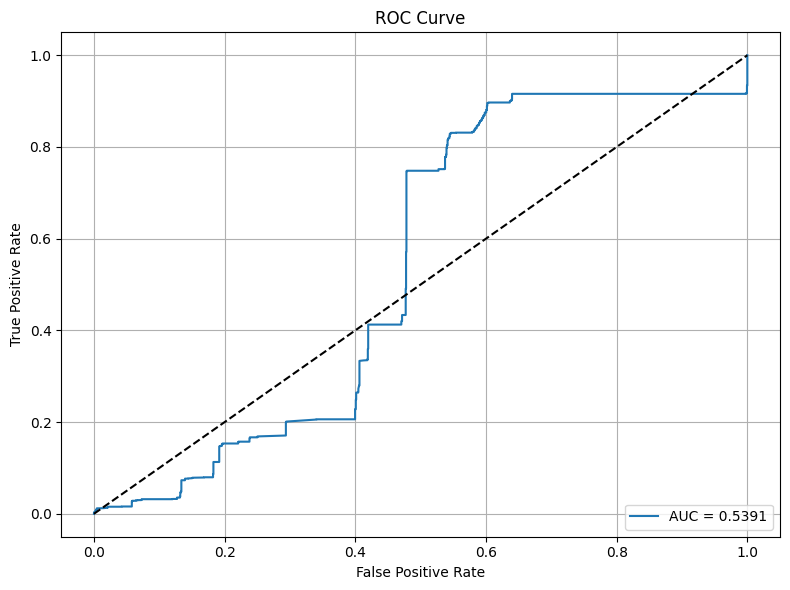


Classification Report:
              precision    recall  f1-score   support

         bot       0.00      0.00      0.00      1794
       human       0.53      0.99      0.69      2009

    accuracy                           0.53      3803
   macro avg       0.26      0.50      0.34      3803
weighted avg       0.28      0.53      0.36      3803



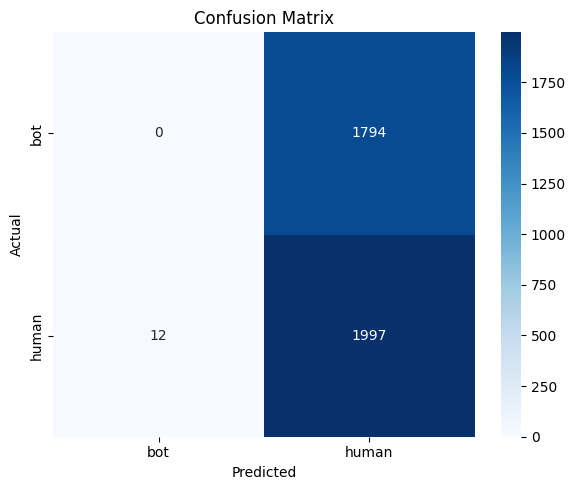

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Uji model
model.eval()
all_probs = []
all_preds = []
all_labels = []

with torch.no_grad():
    for x_text, x_num, y in test_loader:
        x_text, x_num = x_text.to(device), x_num.to(device)
        outputs = model(x_text, x_num)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        all_probs.extend(probs)
        all_preds.extend(preds)
        all_labels.extend(y.numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

# Cek jumlah kelas
num_classes = len(np.unique(all_labels))

# === ROC AUC ===
if num_classes == 2:
    auc_score = roc_auc_score(all_labels, all_probs[:, 1])
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs[:, 1])

    print(f"\nROC AUC Score: {auc_score:.4f}")

    # Plot ROC Curve
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.tight_layout()
    plt.show()
else:
    try:
        auc_score = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro')
        print(f"\nMulticlass ROC AUC Score (OvR): {auc_score:.4f}")
    except ValueError:
        print("\nROC AUC Score could not be computed for this data.")

# === Classification Report ===
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=le.classes_))

# === Confusion Matrix ===
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from scipy.stats import chi2_contingency

# Matriks kebingungan
conf_matrix = np.array([[1693, 299],
                        [294, 1714]])

chi2, p_value, dof, expected = chi2_contingency(conf_matrix)

print("Chi-square statistic:", chi2)
print("p-value:", p_value)


Chi-square statistic: 1976.8049262546342
p-value: 0.0


In [ ]:
os.makedirs("output", exist_ok=True)

# Save model
torch.save(model.state_dict(), "output/model.pth")

# Save vocab
with open("output/vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)

# Save scaler
with open("output/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Save label encoder
with open("output/label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

# Save history
with open("output/history.json", "w") as f:
    json.dump(history, f)

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("output/confusion_matrix.png")
plt.close()

In [ ]:
# ================== Auto-generate README.md ===================
readme_text = f"""# 🧠 Bot Detector LSTM

Model deteksi akun bot berbasis teks dan fitur numerik menggunakan LSTM.

---

## 📈 History Training

| Epoch | Loss  | Accuracy | Precision | Recall | F1-Score |
|:-----:|:-----:|:--------:|:---------:|:------:|:--------:|
"""

# Pastikan history juga menyimpan precision, recall, dan f1:
# history = {
#     "epoch": [...],
#     "loss": [...],
#     "accuracy": [...],
#     "precision": [...],
#     "recall": [...],
#     "f1": [...]
# }

for ep, loss, acc, prec, rec, f1 in zip(
    history["epoch"], history["loss"], history["accuracy"],
    history["precision"], history["recall"], history["f1_score"]
):
    readme_text += f"| {ep} | {loss:.4f} | {acc:.4f} | {prec:.4f} | {rec:.4f} | {f1:.4f} |\n"

readme_text += f"""
---

## 📊 Confusion Matrix

![Confusion Matrix](confusion_matrix.png)

---

## 📦 Files

- `model.pth`
- `vocab.pkl`
- `scaler.pkl`
- `label_encoder.pkl`
- `history.json`
- `confusion_matrix.png`

---

## 🚀 Cara Load Model

```python
import torch
from model import BotDetector
import pickle

# Load model
model = BotDetector(
    vocab_size=VOCAB_SIZE,  # Ganti dengan ukuran vocab kamu
    embed_dim=100,
    hidden_dim=128,
    num_numeric=4,  # Jumlah fitur numerik
    output_dim=2    # Jumlah kelas
)
model.load_state_dict(torch.load("model.pth"))
model.eval()

# Load scaler, vocab, dan label encoder
with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

with open("vocab.pkl", "rb") as f:
    vocab = pickle.load(f)

with open("label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

---

### ⚠️ Pastikan kamu sudah mencatat metric ke `history` saat training:
Tambahkan ini di bagian evaluasi per epoch:

```python
from sklearn.metrics import precision_score, recall_score, f1_score

# Setelah menghitung all_preds dan all_labels
prec = precision_score(all_labels, all_preds, average="macro", zero_division=0)
rec = recall_score(all_labels, all_preds, average="macro", zero_division=0)
f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)

history["precision"].append(prec)
history["recall"].append(rec)
history["f1"].append(f1)
"""

In [ ]:
with open("output/README.md", "w", encoding="utf-8") as f:
    f.write(readme_text)

print("✅ README.md berhasil disimpan di folder output/")

✅ README.md berhasil disimpan di folder output/


In [ ]:
login()

In [ ]:
from huggingface_hub import HfApi, HfFolder, Repository, create_repo, upload_folder

# ============== Setup Hugging Face Token ==============

HF_TOKEN = ""  # <== Ganti dengan token kamu!

api = HfApi()
username = api.whoami(token=HF_TOKEN)["name"]
repo_name = "bot-detector-lstm"  # <== Ganti nama repo sesuai keinginanmu
full_repo_name = f"{username}/{repo_name}"

# ============== Cek & Buat Repo di Hugging Face ==============

try:
    create_repo(repo_name, token=HF_TOKEN, private=False)
    print(f"✅ Repo baru '{full_repo_name}' berhasil dibuat.")
except Exception as e:
    print(f"⚠️ Repo '{full_repo_name}' mungkin sudah ada. Lewat...")

# ============== Upload Folder ==============

upload_folder(
    folder_path="output",
    path_in_repo=".",
    repo_id=full_repo_name,
    token=HF_TOKEN,
    commit_message="🚀 Upload initial model and files."
)

print(f"🎯 Semua file berhasil di-upload ke https://huggingface.co/{full_repo_name}")


⚠️ Repo 'yazidsupriadi/bot-detector-lstm' mungkin sudah ada. Lewat...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/hf_api.py:9635: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")


model.pth:   0%|          | 0.00/15.1M [00:00<?, ?B/s]

🎯 Semua file berhasil di-upload ke https://huggingface.co/yazidsupriadi/bot-detector-lstm
